# 尋找羅吉斯迴歸的係數

## 視覺化原始資料
鐵達尼號資料集  
繪製一個，橫軸:Fare、縱軸:Age的散步圖，並將生存與死亡以不同顏色標記 

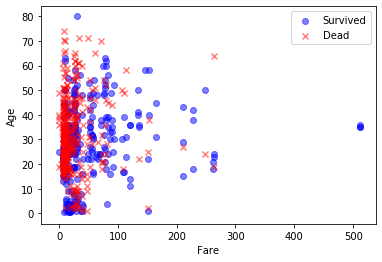

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

labeled = pd.read_csv("https://storage.googleapis.com/kaggle_datasets/Titanic-Machine-Learning-from-Disaster/train.csv")
# Removed observations without Age
labeled = labeled[~labeled["Age"].isna()]
survived = labeled[labeled["Survived"] == 1]
dead = labeled[labeled["Survived"] == 0]
plt.scatter(survived["Fare"], survived["Age"], label="Survived", color="blue", marker="o", alpha=0.5)
plt.scatter(dead["Fare"], dead["Age"], label="Dead", color="red", marker="x", alpha=0.5)
plt.xlabel("Fare")
plt.ylabel("Age")
plt.legend()
plt.show()

## sigmoid函數
將迴歸模型所獲得的數值輸出經過sigmoid函數映射到0-1之間

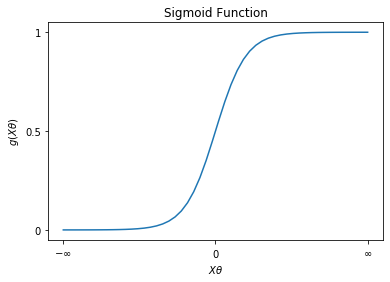

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(z):
    return 1/(1 + np.exp(-z))

x_arr = np.linspace(-10, 10)
y_arr = np.array(list(map(sigmoid, x_arr)))
plt.plot(x_arr, y_arr)
plt.xticks([-10, 0, 10], ["$-\infty$", "$0$", "$\infty$"])
plt.yticks([0, 0.5, 1], ["0", "0.5", "1"])
plt.xlabel("$X\\theta$")
plt.ylabel("$g(X\\theta)$")
plt.title("Sigmoid Function")
plt.show()

## 成本函數
迴歸模型所使用的成本函數為MSE  
而分類模型則需設計一個:  
- 成本在正確分類的情形下趨近於零
- 成本在錯誤分類的情形下趨近於無限大  
可以透過對數函數達成這樣的設計  

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


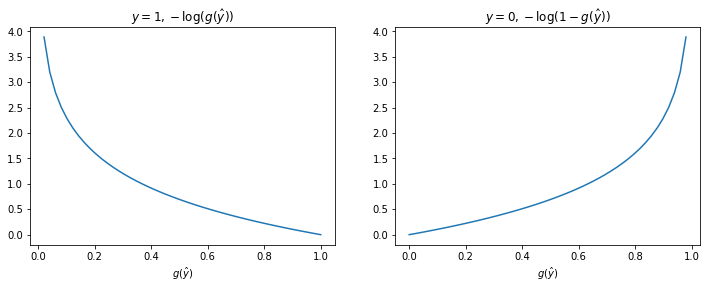

In [3]:
import numpy as np
import matplotlib.pyplot as plt

x_arr = np.linspace(0, 1)
y_arr_0 = -np.log(x_arr)
y_arr_1 = -np.log(1 - x_arr)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(x_arr, y_arr_0)
axes[0].set_title("$y=1,-\log(g(\hat{y}))}$")
axes[0].set_xlabel("$g(\hat{y})$")
axes[1].plot(x_arr, y_arr_1)
axes[1].set_title("$y=0, -\log(1 - g(\hat{y}))$")
axes[1].set_xlabel("$g(\hat{y})$")
plt.show()

將符合需求的兩個函數整合成一個成本函數

In [4]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def cost_function(thetas, X, y):
    m = X.shape[0]
    h = sigmoid(X.dot(thetas))
    J = -1*(1/m)*(np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y))
    # log(0) approached -Inf results in NaN
    if np.isnan(J[0]):
        return(np.inf)
    else:
        return(J[0])
    


## 尋找羅吉斯迴歸的係數

對成本函數偏微分，之後得到了梯度遞減演算法中每次迭代所需要更新的梯度計算公式，如下:

In [5]:
def gradient(thetas, X, y):
    m = y.size
    h = sigmoid(X.dot(thetas.reshape(-1,1)))
    grad =(1/m)*X.T.dot(h-y)
    return(grad.ravel())

需要初始化一組係數向量(通常設定0)，就可以利用GD找到一組能讓成本函數最小化的係數向量  
在此，利用 scipy.optimize 中的 minimize() 找到 Fare 與 Age 的係數向量

In [6]:

from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

labeled = pd.read_csv("https://storage.googleapis.com/kaggle_datasets/Titanic-Machine-Learning-from-Disaster/train.csv")
# Removed observations without Age
labeled = labeled[~labeled["Age"].isna()]
train, validation = train_test_split(labeled, test_size=0.3, random_state=123)
X_train = train.loc[:, ["Age", "Fare"]].values
ones = np.ones(X_train.shape[0]).reshape(-1, 1)
X_train = np.concatenate([ones, X_train], axis=1)
y_train = train.loc[:, "Survived"].values.reshape(-1, 1)
initial_thetas = np.zeros(X_train.shape[1])
res = minimize(cost_function, initial_thetas, args=(X_train, y_train), method=None, jac=gradient, options={'maxiter':400})
thetas = res.x.reshape(-1, 1)
print(thetas)

[[-0.62176132]
 [-0.01014703]
 [ 0.01692017]]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


獲得係數向量後，將它與驗證資料相乘並輸入Sigmoid函數，就可以獲得預測值

In [7]:
X_validation = validation.loc[:, ["Age", "Fare"]].values
ones = np.ones(X_validation.shape[0]).reshape(-1, 1)
X_validation = np.concatenate([ones, X_validation], axis=1)
y_hat = np.dot(X_validation, thetas)
print("Before Sigmoid transform:")
print(y_hat[:5])
g_y_hat = sigmoid(y_hat)
print("After Sigmoid transform:")
print(g_y_hat[:5])

Before Sigmoid transform:
[[-0.41524398]
 [-0.78135263]
 [-0.78939634]
 [-0.65171855]
 [ 1.03819849]]
After Sigmoid transform:
[[0.39765538]
 [0.31402844]
 [0.3122983 ]
 [0.34260237]
 [0.73850225]]


## step函數
將模型輸出利用Sigmoid函數映射到0-1之間後  
再用step函數將機率映射到0、1兩個離散值，常用門檻是0.5

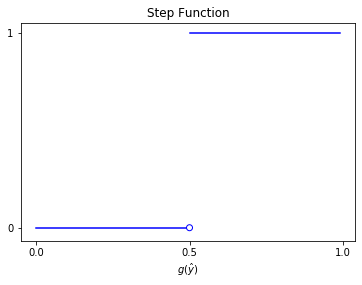

In [8]:
import numpy as np
import matplotlib.pyplot as plt
  
x_arr_0 = np.arange(0, 0.5, 0.01)
x_arr_1 = np.arange(0.5, 1, 0.01)
y_arr_0 = np.where(x_arr_0 >= 0.5, 1, 0)
y_arr_1 = np.where(x_arr_1 >= 0.5, 1, 0)
plt.plot(x_arr_0, y_arr_0, color="b")
plt.plot(x_arr_1, y_arr_1, color="b")
plt.scatter([0.5], [0], facecolors='none', edgecolors='b')
plt.xticks([0, 0.5, 1])
plt.yticks([0, 1])
plt.xlabel("$g(\hat{y})$")
plt.title("Step Function")
plt.show()

def step(g_y_hat, threshold=0.5):
  return np.where(g_y_hat >= threshold, 1, 0).reshape(-1, 1)

In [9]:
y_pred = step(g_y_hat)
print("After Step transform:")
print(y_pred[:5])

After Step transform:
[[0]
 [0]
 [0]
 [0]
 [1]]


## 使用模組與套件尋找係數
使用 sklearn.linear_model 中的  LogisticRegression 尋找係數  
再用 .fit()方法投入訓練資料

In [10]:
from sklearn.linear_model import LogisticRegression

labeled = pd.read_csv("https://storage.googleapis.com/kaggle_datasets/Titanic-Machine-Learning-from-Disaster/train.csv")
# Removed observations without Age
labeled = labeled[~labeled["Age"].isna()]
train, validation = train_test_split(labeled, test_size=0.3, random_state=123)
X_train = train.loc[:, ["Age", "Fare"]].values
y_train = train.loc[:, "Survived"].values
logistic_clf = LogisticRegression()
logistic_clf.fit(X_train, y_train)
fit_intercept = logistic_clf.intercept_.reshape(-1, 1)
fit_coef = logistic_clf.coef_.reshape(-1, 1)
thetas = np.concatenate([fit_intercept, fit_coef])
X_validation = validation.loc[:, ["Age", "Fare"]].values
ones = np.ones(X_validation.shape[0]).reshape(-1, 1)
X_validation = np.concatenate([ones, X_validation], axis=1)
y_hat = np.dot(X_validation, thetas)
g_y_hat = sigmoid(y_hat)
y_pred = step(g_y_hat)
y_true = validation.loc[:, "Survived"].values.reshape(-1, 1)
print("Thetas from sklearn:")
print(thetas)
print("Before Sigmoid transform:")
print(y_hat[:5])
print("After Sigmoid transform:")
print(g_y_hat[:5])
print("After Step transform:")
print(y_pred[:5])
print("True condition:")
print(y_true[:5])

Thetas from sklearn:
[[-0.58965696]
 [-0.01094766]
 [ 0.01680808]]
Before Sigmoid transform:
[[-0.40012884]
 [-0.80026166]
 [-0.78308464]
 [-0.63243339]
 [ 1.0436855 ]]
After Sigmoid transform:
[[0.40128138]
 [0.30996955]
 [0.31365546]
 [0.34695898]
 [0.7395605 ]]
After Step transform:
[[0]
 [0]
 [0]
 [0]
 [1]]
True condition:
[[1]
 [0]
 [1]
 [1]
 [0]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## 在散佈圖繪製決策邊界

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


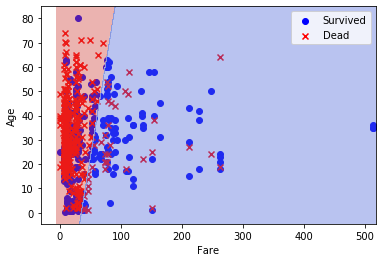

In [11]:

labeled = pd.read_csv("https://storage.googleapis.com/kaggle_datasets/Titanic-Machine-Learning-from-Disaster/train.csv")
# Removed observations without Age
labeled = labeled[~labeled["Age"].isna()]
survived = labeled[labeled["Survived"] == 1]
dead = labeled[labeled["Survived"] == 0]
train, validation = train_test_split(labeled, test_size=0.3, random_state=123)
X_train = train.loc[:, ["Fare", "Age"]].values
y_train = train.loc[:, "Survived"].values
logistic_clf = LogisticRegression()
logistic_clf.fit(X_train, y_train)
fit_intercept = logistic_clf.intercept_.reshape(-1, 1)
fit_coef = logistic_clf.coef_.reshape(-1, 1)
thetas = np.concatenate([fit_intercept, fit_coef])
# Decision boundary plot
fare_min, fare_max = labeled["Fare"].min(), labeled["Fare"].max()
age_min, age_max = labeled["Age"].min(), labeled["Age"].max()
fare_arr = np.linspace(fare_min - 5, fare_max + 5, 1000)
age_arr = np.linspace(age_min - 5, age_max + 5, 1000)
xx, yy = np.meshgrid(fare_arr, age_arr)
ones = np.ones(xx.size).reshape(-1, 1)
X_grid = np.concatenate([ones, xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)
y_grid = np.dot(X_grid, thetas)
g_y_grid = sigmoid(y_grid)
y_grid_pred = step(g_y_grid)
Z = y_grid_pred.reshape(xx.shape)
plt.scatter(survived["Fare"], survived["Age"], label="Survived", marker="o", color="blue")
plt.scatter(dead["Fare"], dead["Age"], label="Dead", marker="x", color="red")
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.coolwarm_r)
plt.legend(loc="upper right")
plt.xlabel("Fare")
plt.ylabel("Age")
plt.show()